### Inference Analysis



# Proposal of baseline scores: 

Option 1: 
I propose giving an average on the three images (n_predictions =3) as the baseline dice score as option one
so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers
##found in last cell in effect of support set sizes


Option 2: 
Do the same but adding ensembling. 
##found at the end of this file


In [1]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import itertools
import math
import einops as E
import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
    # Define input and mask folders for the JNU_FMI dataset
    test_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test'
    test_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test'
    
    support_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\train'
    support_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\train'
    
    # Define output folder for segmented images
    #output_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\segmented_images'
    

In [3]:


current_directory = os.getcwd()
print("Current directory:", current_directory)

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the current directory:")
for item in contents:
    print(item)


Current directory: C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\universeg
Contents of the current directory:
.ipynb_checkpoints
Baseline using Universeg.ipynb
baseline_accuracy.csv
baseline_dicescore.csv
baseline_jaccard.csv
baseline_precision.csv
baseline_sensitivity.csv
inference_analysis.ipynb
label_path
model.py
nn
training.py
universeg_scratch.py
validation.py
__init__.py
__pycache__


In [4]:
# !git clone https://github.com/JJGO/UniverSeg
# !python -m pip install -r ./UniverSeg/requirements.txt
# # Add package directory to path
#!pip install torch


import torch
from model import universeg

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Instantiate the model and move it to the device
model = universeg(pretrained=True)
model.to(device)



UniverSeg(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_blocks): ModuleList(
    (0): CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
      (support): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1-3): 3 x CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_si

In [5]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device('cuda')
    model.to(device)
    print("Model moved to CUDA (GPU)")
else:
    print("CUDA is not available. Model remains on CPU.")


Model moved to CUDA (GPU)


In [6]:
#torch.cuda.get_arch_list()

### funtions for processing images 


### creating bounding boxes


In [7]:
# import PIL
# import numpy as np
# import pathlib
# from typing import Tuple
# 
# def process_image_with_bboxes(image_path: pathlib.Path, seg_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> Tuple[np.ndarray, np.ndarray]:
#     """Process input image and segmentation mask with bounding boxes."""
#     # Process input image
#     img = process_image(image_path, size, augment=False)  # Disable augmentation for image
#     
#     # Process segmentation mask and get bounding boxes
#     seg, bounding_boxes = process_seg(seg_path, size)
#     
#     # Optionally adjust bounding boxes
#     bounding_boxes = adjust_bounding_boxes(bounding_boxes, size)
#     
#     # Draw bounding boxes on the input image
#     img_with_bboxes = draw_bounding_boxes(img, bounding_boxes)
#     
#     return img_with_bboxes, seg
# 
# def process_image(path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
#     """Process input image."""
#     img = PIL.Image.open(path)
#     
#     # Resize image
#     img = img.resize(size, resample=PIL.Image.BILINEAR)
#     
#     if augment:
#         # Random horizontal flipping
#         if random.random() < 0.5:
#             img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
# 
#         # Random vertical flipping
#         if random.random() < 0.5:
#             img = img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
# 
#         # Random scaling
#         scale_factor = random.uniform(0.8, 1.2)
#         new_width = int(img.size[0] * scale_factor)
#         new_height = int(img.size[1] * scale_factor)
#         img = img.resize((new_width, new_height), resample=PIL.Image.BILINEAR)
# 
#     
#     # Convert image to grayscale
#     img = img.convert("L")
#     
#     # Convert image to numpy array
#     img = np.array(img, dtype=np.float32)
#     
#     return img
# 
# def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
#     """Process segmentation mask and extract bounding boxes."""
#     seg = PIL.Image.open(path)
#     seg = seg.resize(size, resample=PIL.Image.NEAREST)
#     seg = seg.convert("L")
#     seg = np.array(seg)
#     seg = np.stack([seg == 0, seg == 128, seg == 255])
#     
#     # Get bounding boxes from segmentation mask
#     bounding_boxes = get_bounding_boxes(seg)
#     
#     return seg, bounding_boxes
# 
# def get_bounding_boxes(seg_mask):
#     # Convert the segmentation mask back to a single-channel image
#     seg_mask = np.argmax(seg_mask, axis=0).astype(np.uint8)
#     
#     # Find contours of each region in the segmentation mask
#     contours, _ = cv2.findContours(seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     
#     # Calculate bounding boxes for each contour
#     bounding_boxes = []
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         bounding_boxes.append((x, y, x + w, y + h))  # Bounding box coordinates: (x_min, y_min, x_max, y_max)
#     
#     return bounding_boxes
# 
# def adjust_bounding_boxes(bounding_boxes, size):
#     # Optionally adjust bounding boxes to include more context
#     # For example, you can expand each bounding box by a certain factor
#     # Here's a simple example of expanding each bounding box by 10%
#     adjusted_bounding_boxes = []
#     for bbox in bounding_boxes:
#         x_min, y_min, x_max, y_max = bbox
#         width = x_max - x_min
#         height = y_max - y_min
#         delta_x = int(0.1 * width)
#         delta_y = int(0.1 * height)
#         x_min = max(0, x_min - delta_x)
#         y_min = max(0, y_min - delta_y)
#         x_max = min(size[0], x_max + delta_x)
#         y_max = min(size[1], y_max + delta_y)
#         adjusted_bounding_boxes.append((x_min, y_min, x_max, y_max))
#     
#     return adjusted_bounding_boxes
# 
# def draw_bounding_boxes(image, bounding_boxes):
#     # Draw bounding boxes on the input image
#     for bbox in bounding_boxes:
#         x_min, y_min, x_max, y_max = bbox
#         cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Draw rectangle
#     
#     return image


#dice score 30

In [8]:
import PIL
import numpy as np
import pathlib
from typing import Tuple

import PIL
import numpy as np
import pathlib
from typing import Tuple

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img
#     
#     # Load segmentation mask
#     seg = PIL.Image.open(seg_mask_path)
#     seg = seg.resize(size, resample=PIL.Image.NEAREST)
#     seg = seg.convert("L")
#     seg = np.array(seg)
#     
#     # One-hot encoded representation of segmentation mask
#     seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
#     
#     # Apply regions of interest (ROIs) to input image
#     img_with_rois = np.where(seg_mask[0], img, 0)
#     
#     return img_with_rois

# def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
#     """Process input image with hot encoded selection of areas."""
#     # Print the image and mask paths for debugging
#     print("Image path:", image_path)
#     print("Segmentation mask path:", seg_mask_path)
#     
#     try:
#         # Load input image
#         img = PIL.Image.open(image_path)
#         img = img.resize(size, resample=PIL.Image.BILINEAR)
#         img = img.convert("L")
#         img = np.array(img, dtype=np.float32)
#         print(img)
# 
#         # Load segmentation mask
#         seg = PIL.Image.open(seg_mask_path)
#         seg = seg.resize(size, resample=PIL.Image.NEAREST)
#         seg = seg.convert("L")
#         seg = np.array(seg)
# 
#         # One-hot encoded representation of segmentation mask
#         seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
# 
#         # Apply regions of interest (ROIs) to input image
#         img_with_rois = np.where(seg_mask[0], img, 0)
#         
#         return img_with_rois
#     
#     except Exception as e:
#         print("Error occurred while processing image:", e)
#         return None  # Return None to indicate failure




def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
    seg = seg_mask.astype(np.float32)

    return seg

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    # Apply the mask to the input image
    img_with_rois = np.where(seg_mask[0], image, 0)
    img_with_rois = img_with_rois.astype(np.float32)



    return img_with_rois

import cv2



# def process_image_first(path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
#     """Process input image."""
#     img = PIL.Image.open(path)
#     
#     # Resize image
#     img = img.resize(size, resample=PIL.Image.BILINEAR)
#     
#     if augment:
#         # Apply data augmentation techniques if needed
#         pass
#     
#     # Convert image to grayscale
#     img = img.convert("L")
#     
#     # Convert image to numpy array
#     img = np.array(img, dtype=np.float32)
#     
#     return img

# Example usage:
# img_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\images\\test\\20190830T115515_269.png")
# seg_mask_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\masks\\test\\20190830T115515_269_mask.png")

# # Process input image with hot encoded selection of areas
# processed_img = process_image(img_path, seg_mask_path, size=(128, 128), augment=False)
# import matplotlib.pyplot as plt
# 
# # Print the processed image
# plt.imshow(processed_img, cmap='gray')
# plt.axis('off')
# plt.show()



### convex hull

In [9]:
import cv2
import PIL
import numpy as np
import pathlib
from typing import Tuple

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img

def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
    #seg_mask = seg_mask.convert("L")
    seg = seg_mask.astype(np.float32)
    #print(seg)
    

    return seg

import cv2
import numpy as np

# def apply_convex_hull(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
#     """Apply convex hull to regions of interest (ROIs) from segmentation mask on input image."""
#     # Find contours in the segmentation mask
#     contours, _ = cv2.findContours(seg_mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     
#     # Create a mask for the convex hull
#     convex_hull_mask = np.zeros_like(seg_mask[0], dtype=np.uint8)
#     
#     # Draw the convex hull on the mask
#     for contour in contours:
#         hull = cv2.convexHull(contour)
#         cv2.drawContours(convex_hull_mask, [hull], -1, 255, -1)  # -1 for filled
#         
#     # Apply the convex hull mask to the input image
#     img_with_convex_hull = cv2.bitwise_and(image, image, mask=convex_hull_mask)
#     
#     return img_with_convex_hull



# Load the input image and segmentation mask
# img_path = pathlib.Path(".png")
# seg_mask_path = pathlib.Path("path_to_seg_mask.png")

# img_path = pathlib.Path(r"C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test\20190909T155747_689.png")
# seg_mask_path = pathlib.Path(r"C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test\20190909T155747_689_mask.png")
# size = (128, 128)
# 
# img = process_image(img_path, seg_mask_path, size)
# seg_mask = process_seg(seg_mask_path, size)

# Apply convex hull to the processed image and segmentation mask
#img_with_convex_hull = apply_convex_hull(img, seg_mask)

#import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt
# 
# # Display the original image
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.imshow(img, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')
# 
# # Display each channel of the segmentation mask separately
# plt.figure(figsize=(8, 8))
# for i in range(seg_mask.shape[0]):
#     plt.subplot(1, seg_mask.shape[0], i + 1)
#     plt.imshow(seg_mask[i], cmap='gray')
#     plt.title(f'Segmentation Mask Channel {i + 1}')
#     plt.axis('off')
# 
# # # Display the image with convex hull
# # plt.figure(figsize=(8, 8))
# # plt.subplot(1, 2, 2)
# # plt.imshow(img_with_convex_hull, cmap='gray')
# # plt.title('Image with Convex Hull')
# # plt.axis('off')
# 
# plt.show()



### load dataset correct

In [10]:
# def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
#     """Load dataset from input and mask folders."""
#     data = []
#     input_path = pathlib.Path(input_folder)
#     mask_path = pathlib.Path(mask_folder)
# 
#     # Sort images based on numerical values in filenames
#     input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
# 
#     for file in input_files:
#         img = process_image(file,mask_path, size=size)
#         img_name = file.stem
#         # print(img_name)
# 
#        # Load mask
#         seg = None
#         seg_file = mask_path / f"{img_name}_mask.png"
#         if seg_file.exists():
#             seg = process_seg(seg_file, size=size)
#            # print(f"Loaded mask for {img_name}")
#         else:
#             print(f"Mask file '{seg_file}' not found. Skipping.")
#             
#         img_with_rois = apply_rois(img, seg)
# 
#         data.append((img_with_rois / 255.0, seg))
# 
#     return data


# input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\MedSAM\\up_dataset\\us_data\\partitioned_dataset\\images\\test"
# mask_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\MedSAM\\up_dataset\\us_data\\partitioned_dataset\\masks\\test"
# 
# data = load_dataset(input_folder, mask_folder)
# for img, mask in data:
#     print("Image shape:", img.shape)
#     print("Mask shape:", mask.shape)


### with rois

In [11]:
def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    # Sort images based on numerical values in filenames
    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        

    for file in input_files:
        img = process_image(file,mask_path, size=size)
        img_name = file.stem

        # Load segmentation mask
        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        # Apply regions of interest (ROIs) to input image
        img_with_co = img_with_convex_hull(img, seg)

        data.append((img_with_co / 255.0, seg))

    return data


In [12]:
from dataclasses import dataclass
from typing import Optional, Tuple, Literal
import os
import torch
import pathlib
import numpy as np
import PIL.Image
from torch.utils.data import Dataset

@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def __post_init__(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size)
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
         
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            if self.label in self.masks:
                self._ilabel = {"head": 1, "symp": 2, "background": 0}[self.label]
        
        self.idxs = list(range(len(self._data)))
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        img, seg = self._data[self.idxs[idx]]
        # if self.label is not None:
        #     seg = seg[self.label_name][None]
        return img, seg


### Visualizations

In [13]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().astype(np.float32).squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

### Multilabel

In [14]:
# d_support = WBCDataset('JTSC', split='support', label=None)
# d_test = WBCDataset('JTSC', split='test', label=None)

d_support = JNU_FMI(support_input_folder, label=support_mask_folder)
d_test = JNU_FMI(test_input_folder, label=test_mask_folder)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [15]:
# n_viz = 16
# visualize_tensors({
#     'Support Image': support_images[:n_viz],
#     'Support Label': support_labels[:n_viz],
# }, 8, title='Support Set Examples - Multi Label')

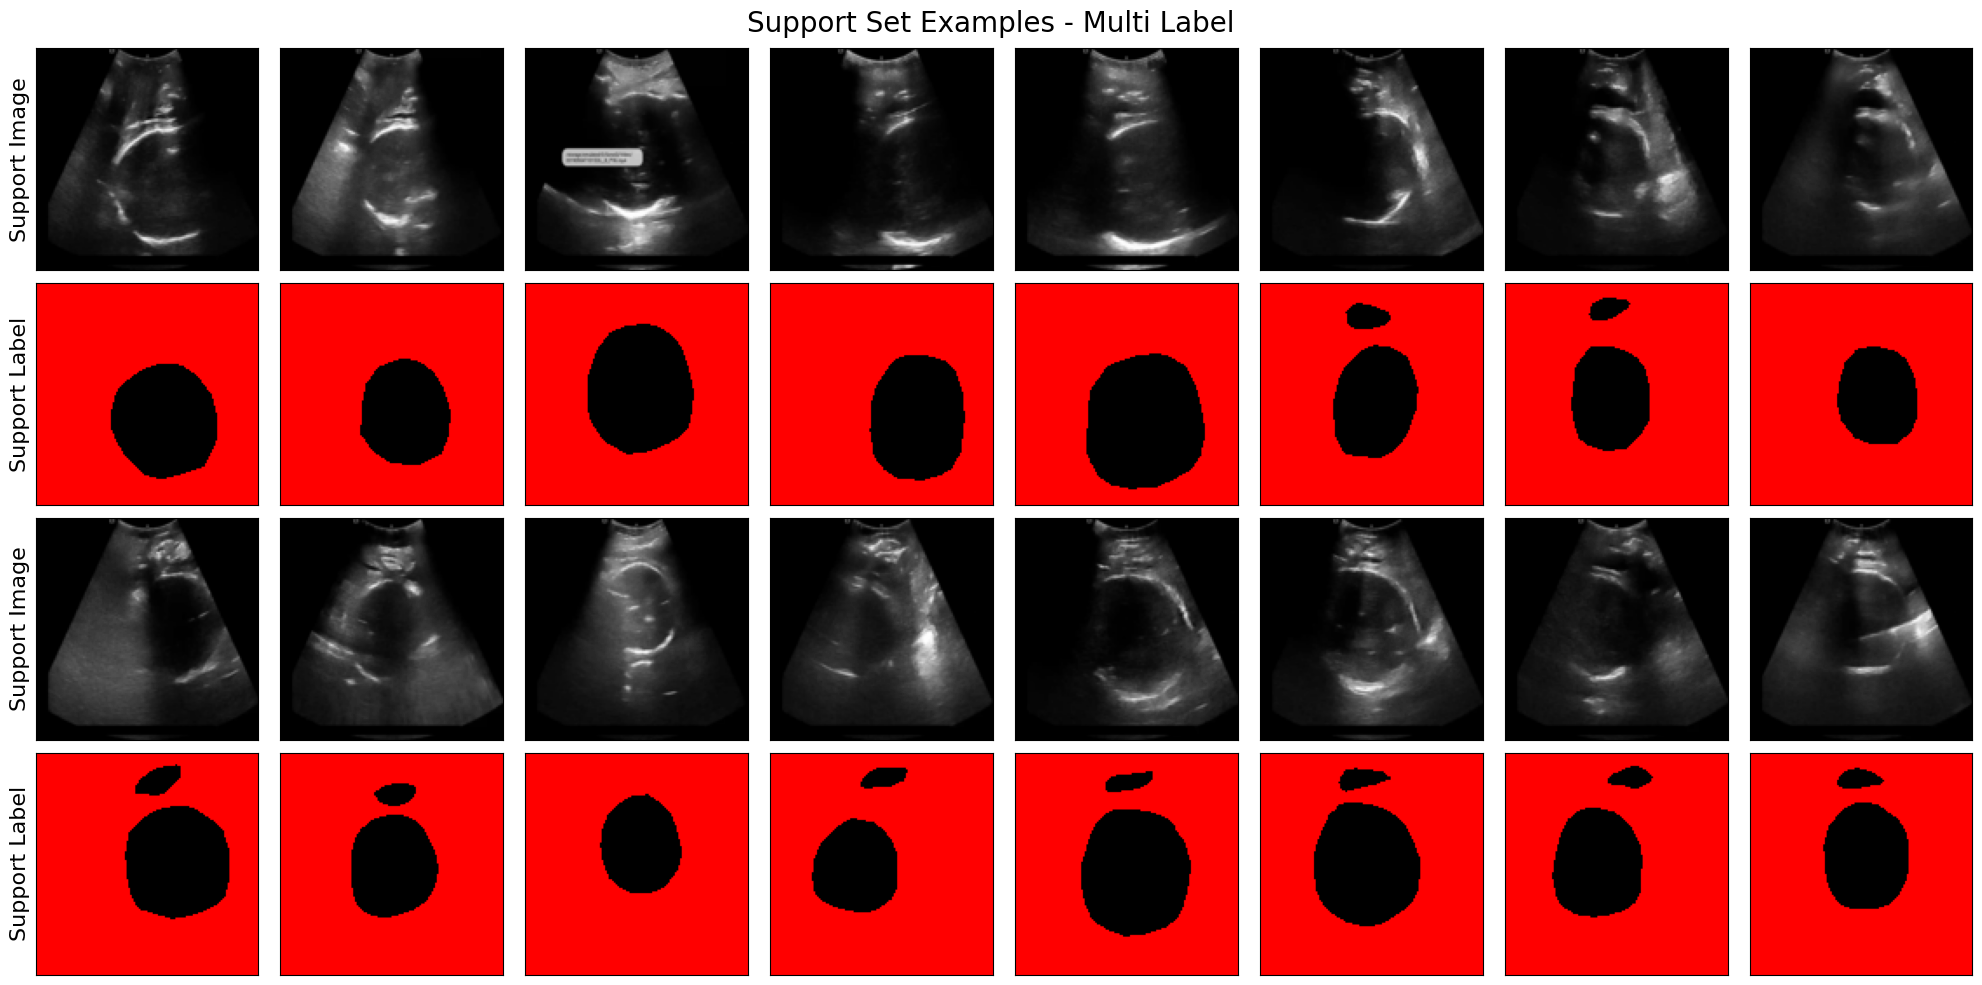

In [16]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz].float(),
    'Support Label': support_labels[:n_viz].float(),
}, 8, title='Support Set Examples - Multi Label')


In [17]:
# prepare a function that will perform inference on all available labels
import torch.nn.functional as F

# Dice metric for measuring volume agreement
def soft_dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    print(2*(y_pred*y_true).sum())
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

@torch.no_grad()
def inference_multi(model, image, label_onehot, support_images, support_labels_onehot):
    # get data
    n_labels = label_onehot.shape[0]
    image, label_onehot = image.to(device), label_onehot.to(device)

    # go through label
    all_logits = []
    soft_pred_onehot = []
    for k in range(n_labels):
        # extract the right label
        label = label_onehot[k:k+1]
        support_labels = support_labels_onehot[:,k:k+1]

        # run inference on this label
        logits = model(
            image[None],
            support_images[None],
            support_labels[None]
        )[0][0] # outputs are logits
        soft_pred = torch.sigmoid(logits)
        soft_pred_onehot.append(soft_pred)

    # get multi-label score
    soft_pred_onehot = torch.stack(soft_pred_onehot)
    hard_pred = F.softmax(10*soft_pred_onehot, dim=0)
    scores = []
    for k in range(n_labels):
        score = soft_dice_score(hard_pred[k], label_onehot[k])
        scores.append(score)

    # return the predictions and labels
    return {'Image': image,
            'Soft Prediction': soft_pred_onehot,
            'Prediction': hard_pred,
            'Ground Truth': label_onehot,
            'score': np.mean(scores)}

 10%|█         | 1/10 [00:03<00:32,  3.58s/it]

tensor(26653.7227, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 20%|██        | 2/10 [00:04<00:18,  2.29s/it]

tensor(26521.8789, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 30%|███       | 3/10 [00:06<00:12,  1.84s/it]

tensor(26373.8613, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 40%|████      | 4/10 [00:07<00:09,  1.63s/it]

tensor(26991.3223, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 50%|█████     | 5/10 [00:08<00:07,  1.51s/it]

tensor(23726.0879, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 60%|██████    | 6/10 [00:10<00:05,  1.45s/it]

tensor(27089.4102, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 70%|███████   | 7/10 [00:11<00:04,  1.41s/it]

tensor(26707.5605, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 80%|████████  | 8/10 [00:12<00:02,  1.38s/it]

tensor(25615.3145, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 90%|█████████ | 9/10 [00:14<00:01,  1.37s/it]

tensor(28650.9746, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

tensor(27762.9941, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


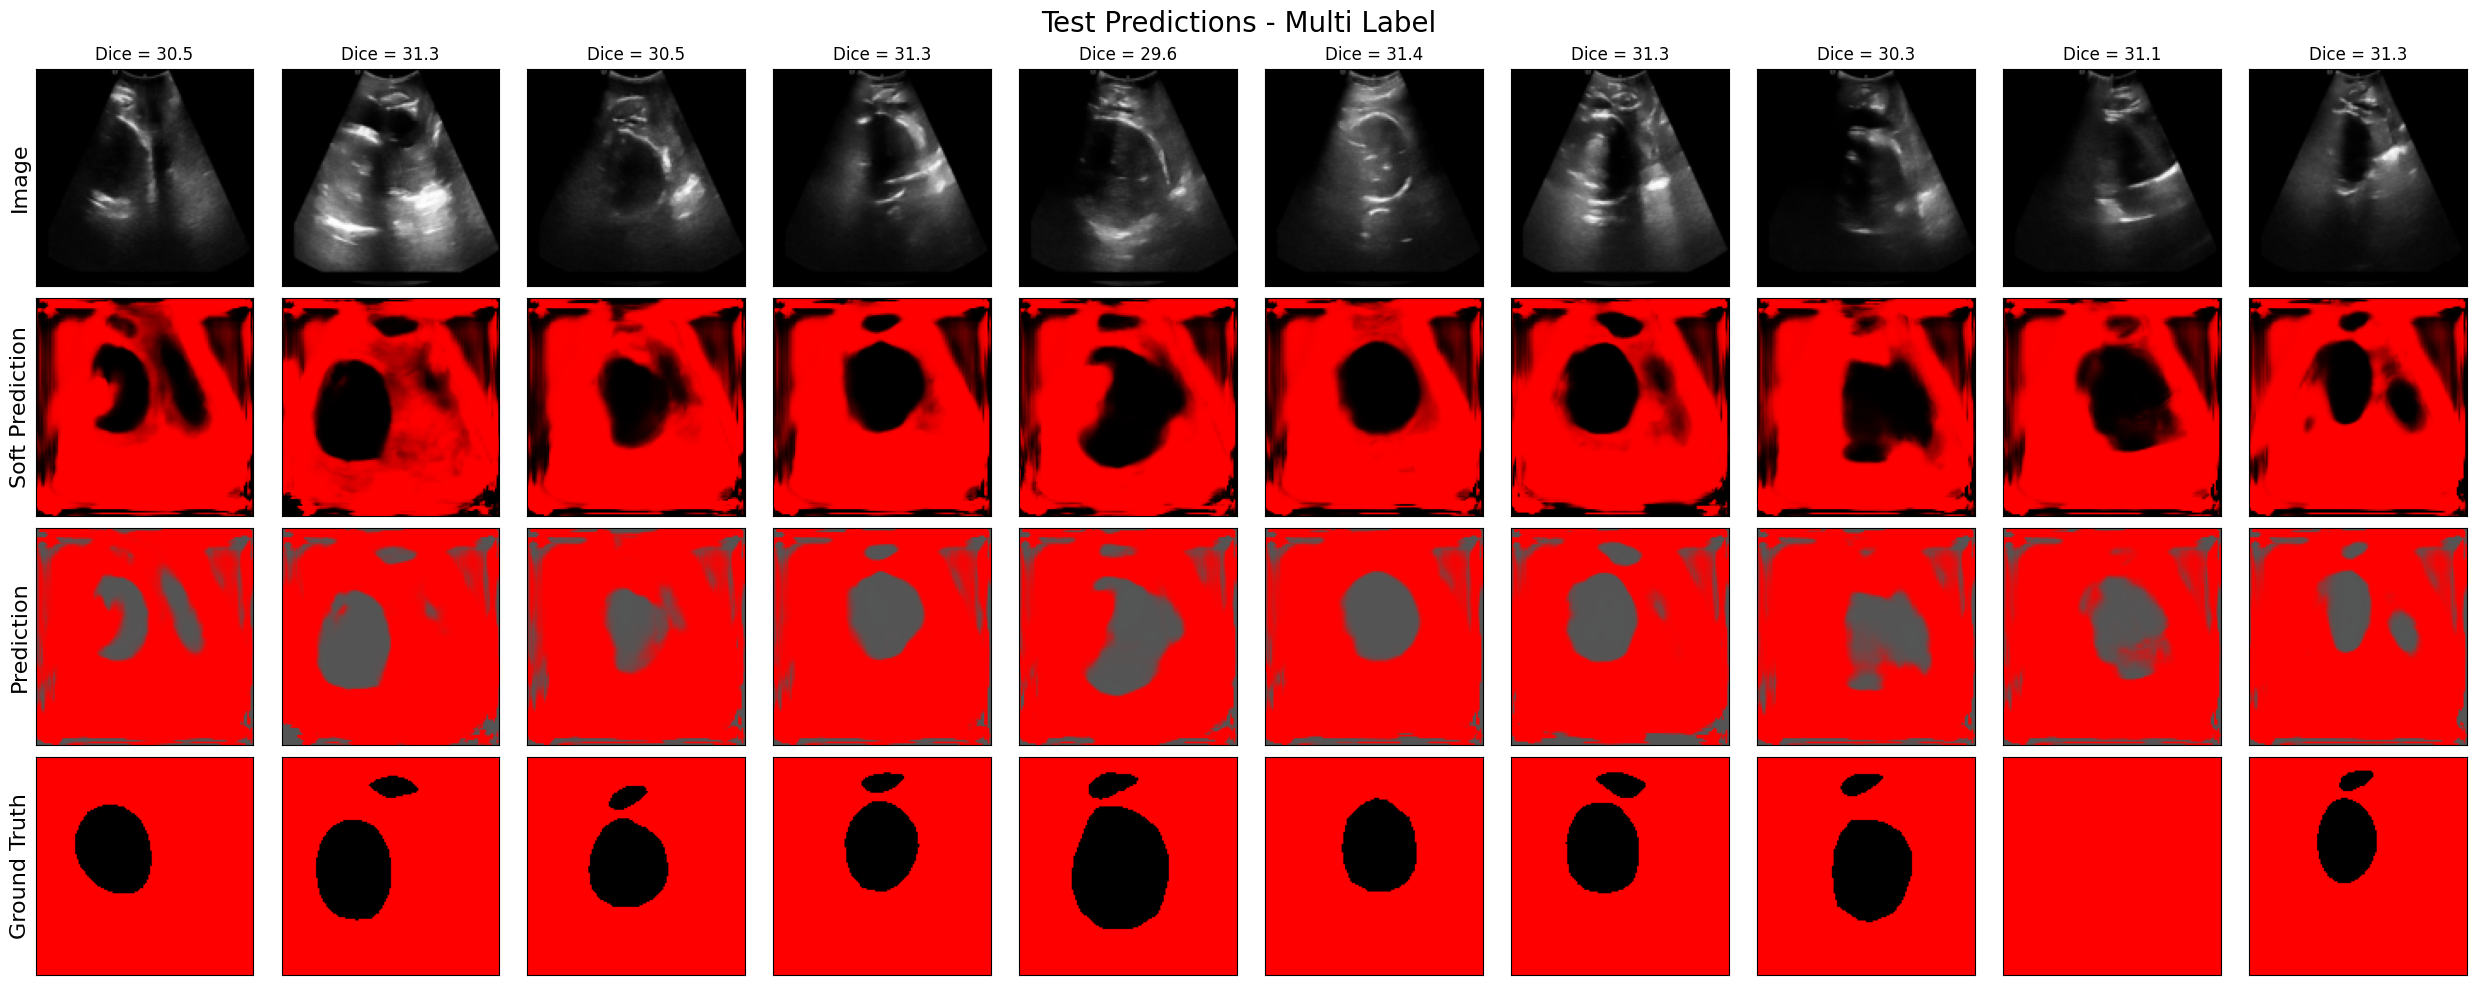

In [18]:
n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference_multi(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

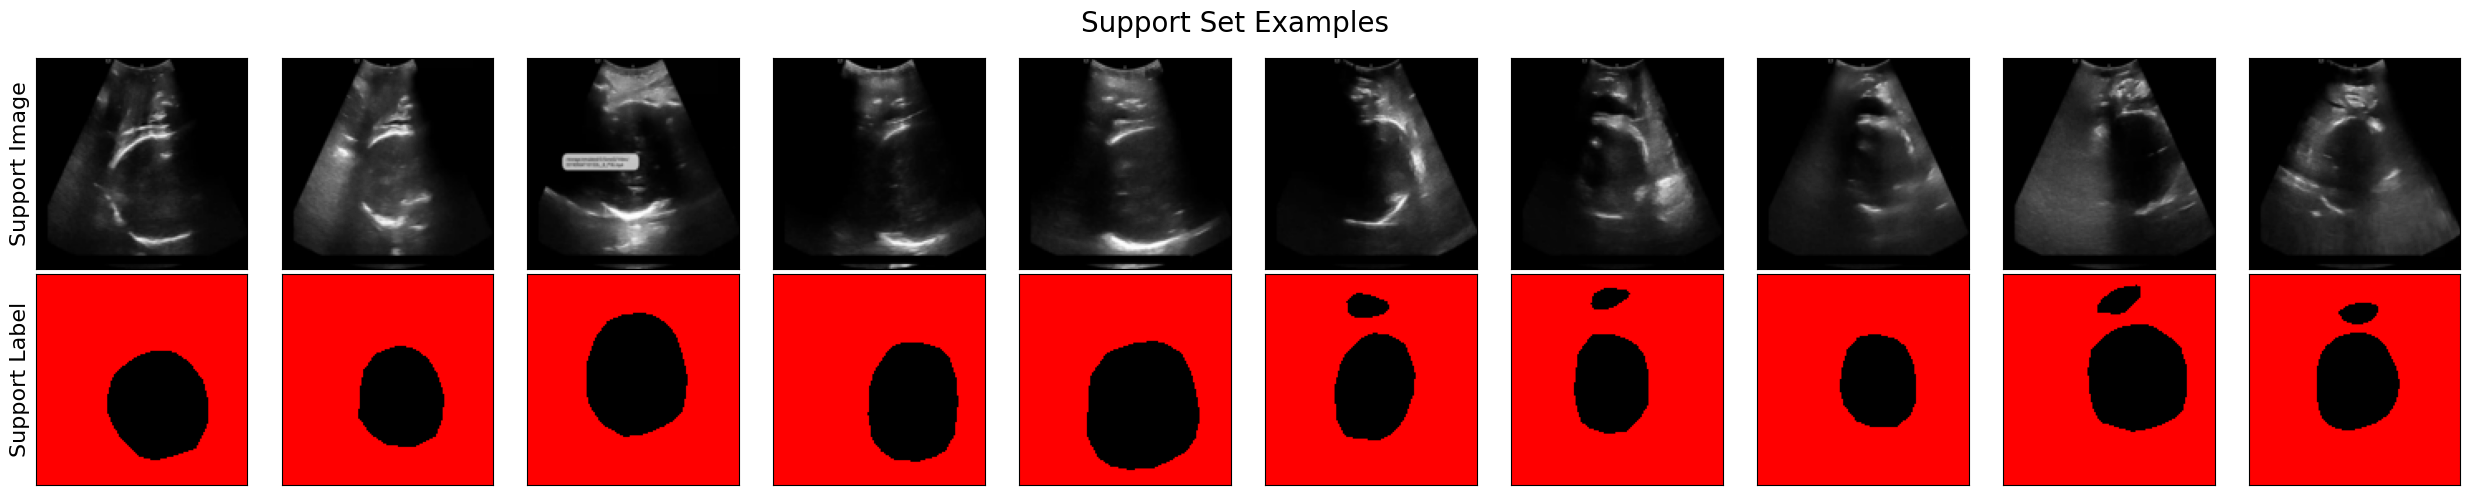

In [19]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

Let's perform inference on a test entry and visualize the prediction

### Inference Analysis


##### Change support labels

In [20]:
# n_support = 64

In [21]:
##changing input not possible at the moment since we only have one dataset

### Effect of the Support Set Size

In [22]:

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)



tensor(18242.8848, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(19018.2461, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(20512.0957, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21273.6328, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21418.9023, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21757.3652, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21648.9688, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21648.9688, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21648.9688, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21648.9688, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(22255.5547, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., devic

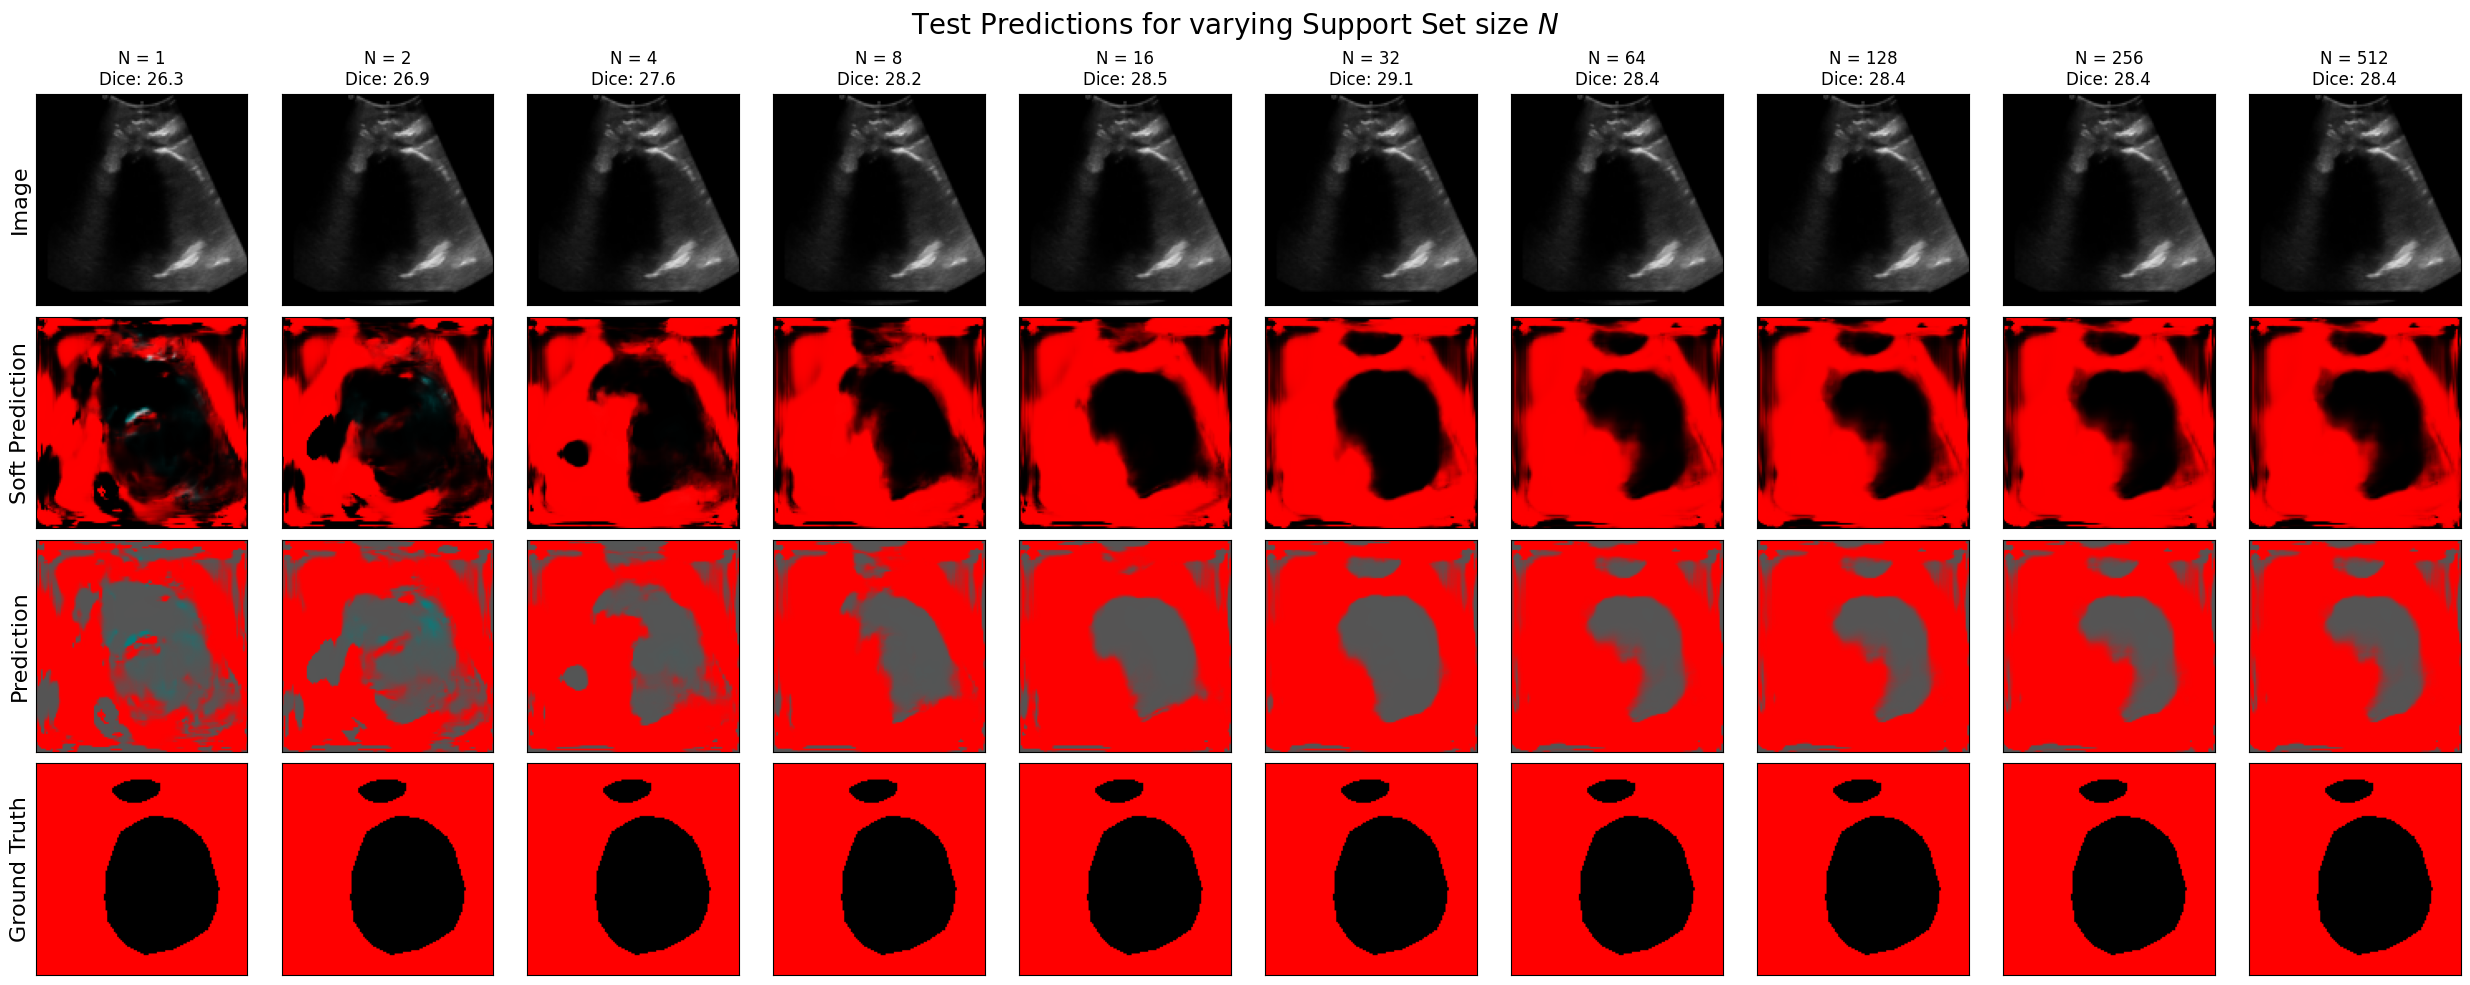

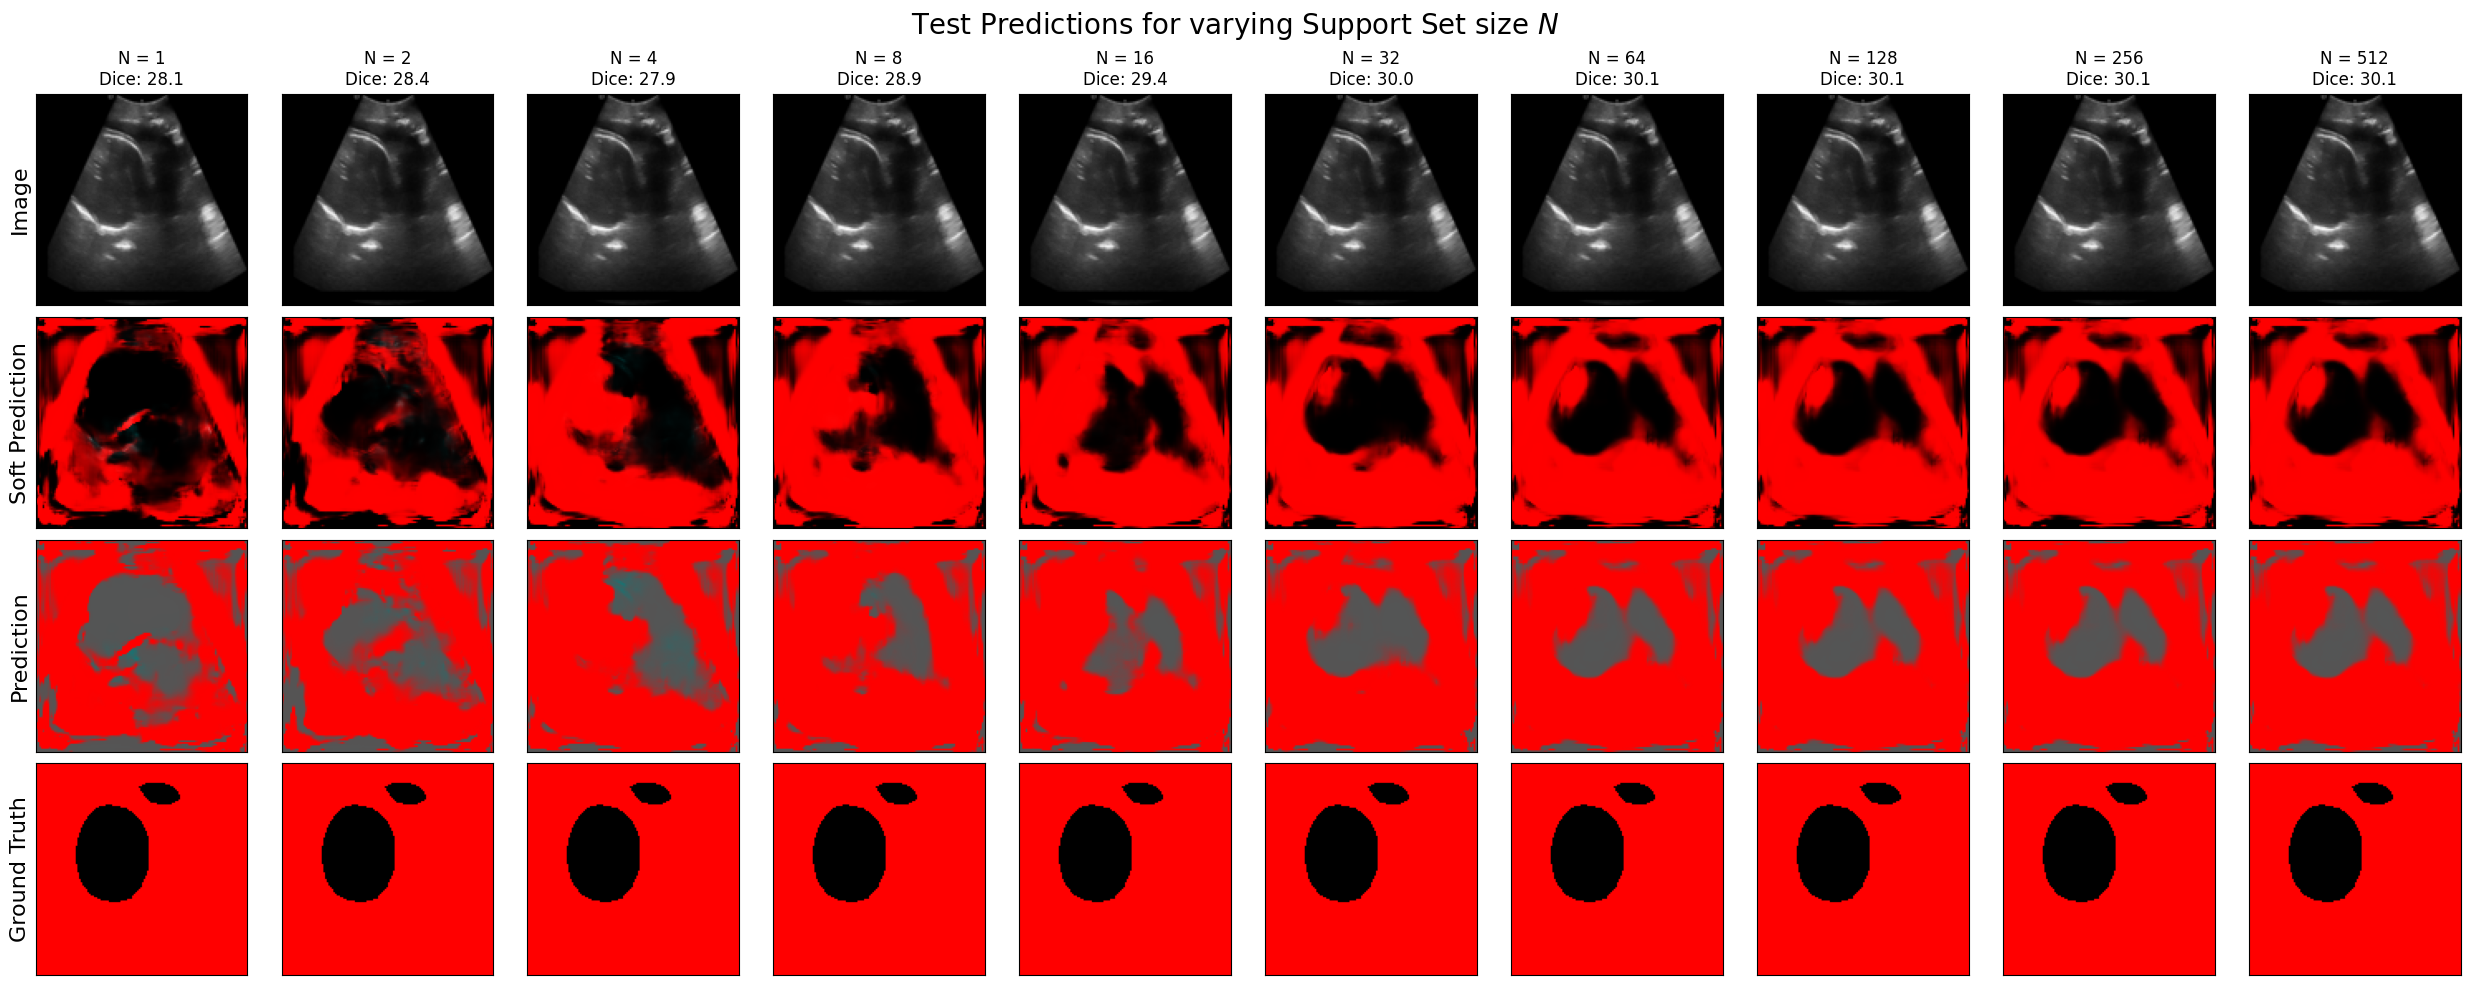

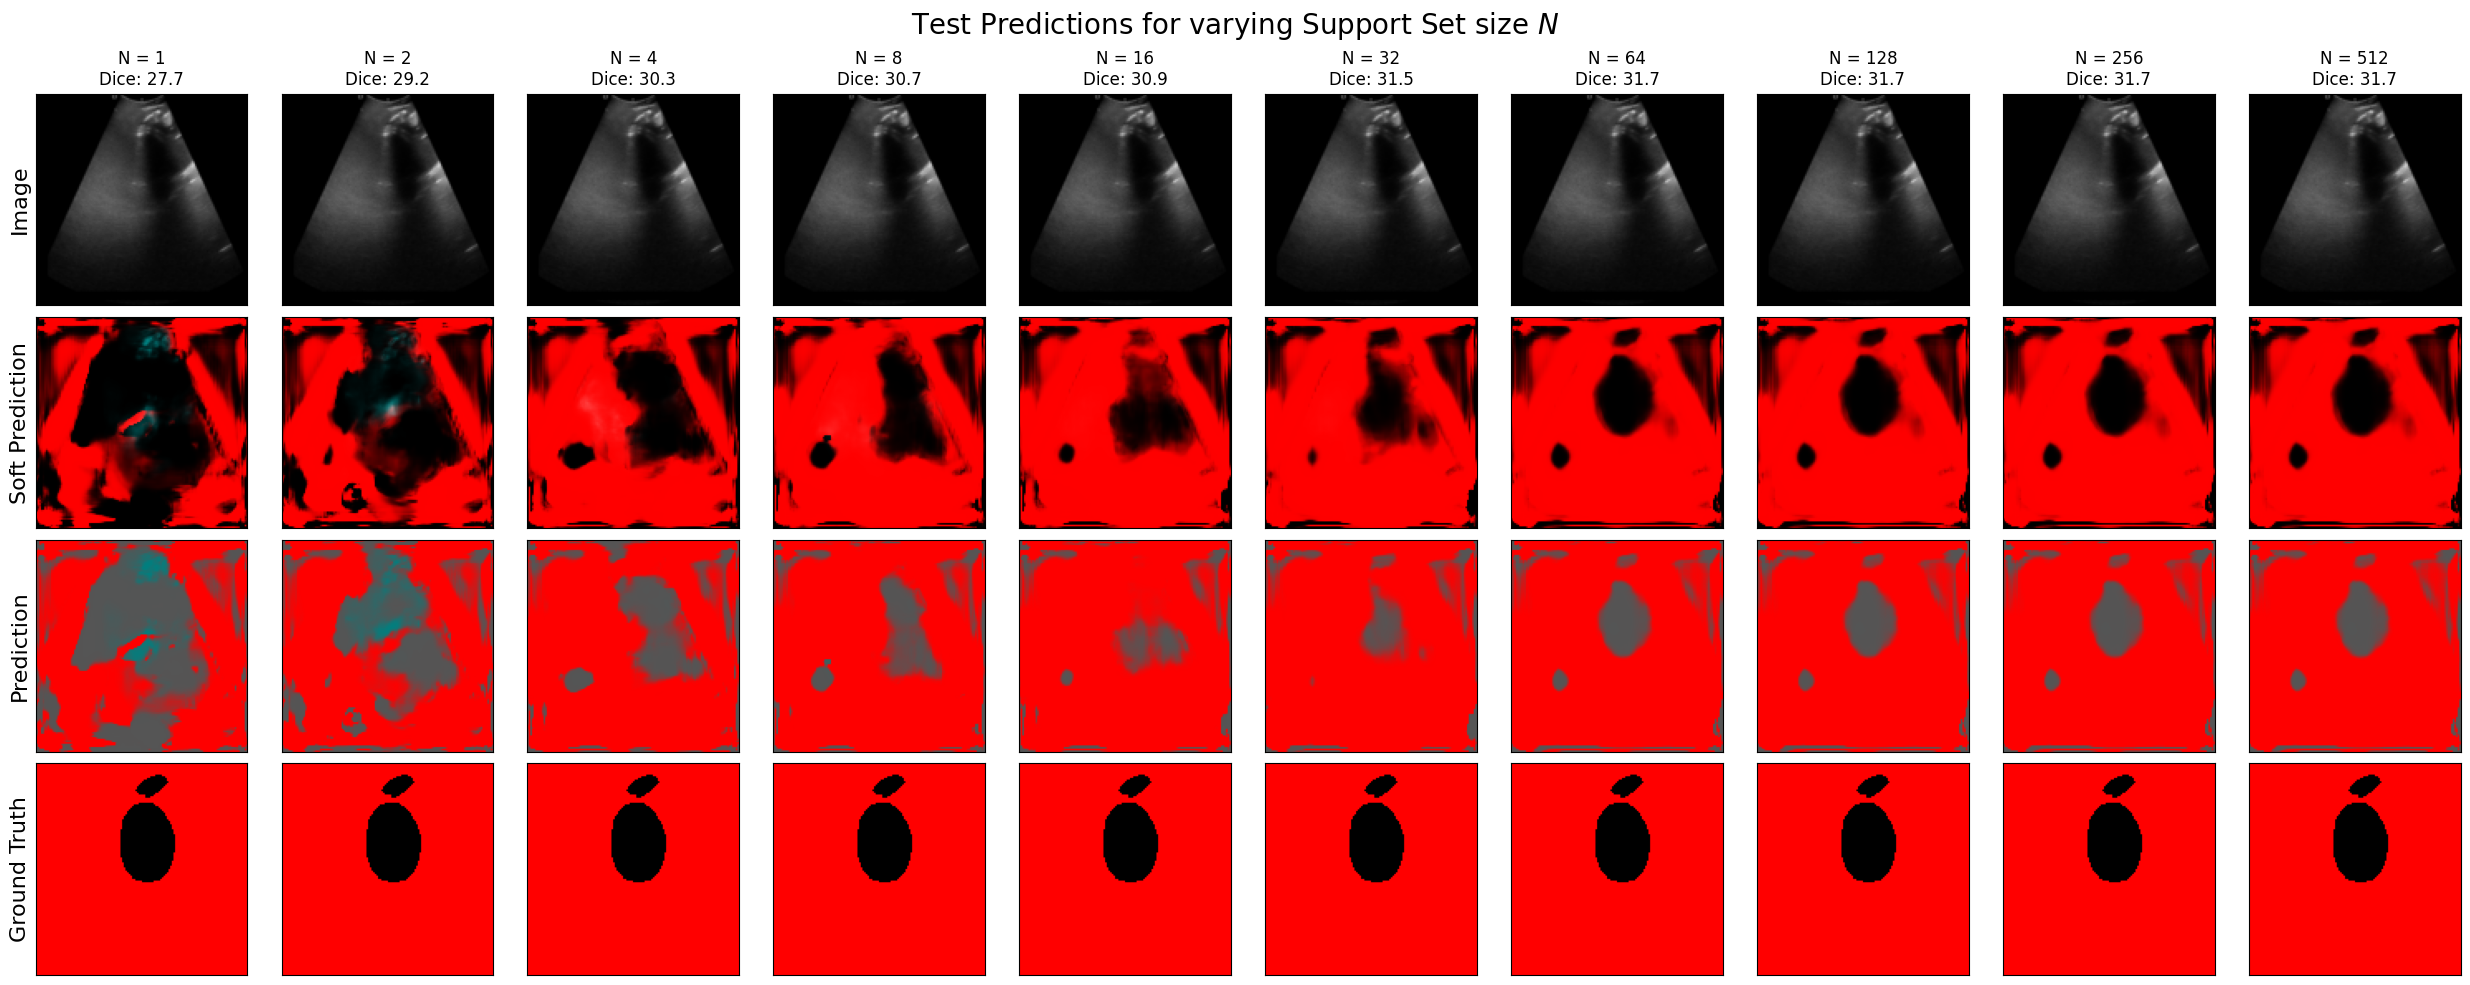

In [23]:
n_predictions = 3 #1446
support_set_sizes = [1, 2, 4, 8, 16, 32, 64,128,256,512]

## why certain pictures random 

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference_multi(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))
# Print the list of Dice scores for different support set sizes
# for N, dice_scores in zip(support_set_sizes, results_dict['Dice Score']):
#     print(f"Support Set Size: {N}, Dice Scores: {dice_scores}")


# Print the list of Dice scores for different support set sizes
# for N, dice_scores in results_dict.items():
#     average_dice_score = np.mean(dice_scores)
#     print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")

# Print the list of Dice scores for different support set sizes


#### Average dice score per support set size

In [24]:
n_predictions = 3  # 1446
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

# Collect dice scores for different support set sizes
results_dict = defaultdict(list)

# why certain pictures random 
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference_multi(model, image, label, support_images[:N], support_labels[:N])
        score = vals['score']
        results_dict[N].append(score)

# Print the list of average Dice scores for each support set
for N, dice_scores in results_dict.items():
    average_dice_score = np.mean(dice_scores)
    print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")


tensor(20934.9727, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(22482.6445, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(23856.6094, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25049.9922, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(24946.6289, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25486.6953, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25591.3809, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(22786.4238, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(24487.5195, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(26804.1953, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(28094.4062, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., devic

In [25]:

# Import necessary libraries
from collections import defaultdict
import numpy as np

# Define variables
n_predictions = 3  # Number of test images to randomly select
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]  # Different support set sizes

# Dictionary to collect dice scores for different support set sizes
results_dict = defaultdict(list)

# Randomly select test images
idxs = np.random.permutation(len(d_test))[:n_predictions]

# Iterate over the selected test images
for i in idxs:
    # Iterate over different support set sizes
    for N in support_set_sizes:
        # Get the test image and its label
        image, label = d_test[i]
        # Perform inference and get the dice score
        vals = inference_multi(model, image, label, support_images[:N], support_labels[:N])
        score = vals['score']
        # Collect the dice score for this support set size
        results_dict[N].append(score)

# Calculate the average Dice score across all support set sizes for each test image
average_dice_scores = []
for i in range(n_predictions):
    dice_scores_for_image = [results_dict[N][i] for N in support_set_sizes]
    average_dice_score_for_image = np.mean(dice_scores_for_image)
    average_dice_scores.append(average_dice_score_for_image)

# Print the average Dice score for each test image
for i, average_dice_score in enumerate(average_dice_scores, start=1):
    print(f"Average Dice Score for random Test Image {i}: {average_dice_score}")

    
    #randomly chosen images, so not like in the index of the original datasets

tensor(21042.4688, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(22606.1523, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(23938.1523, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25040.3652, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(24919.7188, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25508.8887, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25576.0742, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21769.4609, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(23435.9844, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(25640.1230, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(26680.2402, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., devic

In [26]:
##I propose giving an average on the three images as the baseline dice score as option one
#so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers


#### Multi-label Predictions

In [27]:
# d_support = VentricleDataset(support_input_folder, label=None)
# d_test = VentricleDataset(test_input_folder, label=None)
# 
# n_support = 64
# 
# support_images, support_labels = zip(*itertools.islice(d_support, n_support))
# support_images = torch.stack(support_images).to(device)
# support_labels = torch.stack(support_labels).to(device)

### Ensembling Predictions

In [28]:
# # helpful function to sample support data
# def sample_support(seed):
#     rng = np.random.default_rng(seed)
#     idxs = rng.integers(0,len(d_support), size=support_size)
#     support_images, support_labels = zip(*[d_support[i] for i in idxs])
#     support_images = torch.stack(support_images).to(device)
#     support_labels = torch.stack(support_labels).to(device)
#     return support_images, support_labels

In [29]:
# # get support data
# # d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# # d_test = WBCDataset('JTSC', split='test', label='cytoplasm')
# d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
# d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)
# 
# 
# # setup the number of predictions and ensembling
# support_size = 8
# n_predictions = 3
# n_ensemble = 5
# 
# # get various support sets
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# seeds = range(n_ensemble)
# supports = {
#     seed: sample_support(seed)
#     for seed in range(n_ensemble)
# }
# 
# # go through the number of experiments
# for i in idxs:
# 
#     # go through the number of predictions we will ensemble
#     results = defaultdict(list)
#     for j in range(n_ensemble):
#         # get support set and query
#         support_images, support_labels = sample_support(j)
#         image, label = d_test[i]
# 
#         # perform inference
#         vals = inference(model, image, label, support_images, support_labels)
#         for k, v in vals.items():
#             results[k].append(v)
# 
#     results['Image'].append(image)
#     ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
#     results['Soft Prediction'].append(ensemble)
#     results['Prediction'].append(ensemble.round())
#     results['Ground Truth'].append(label)
#     results['score'].append(dice_score(ensemble.round(), label.to(device)))
# 
#     scores = results.pop('score')
#     col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
#     col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
# 
#     visualize_tensors(results,
#                       col_names=col_names,
#                       title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
#                       col_wrap=n_ensemble+1)

In [30]:
##option 2 would be doing same as option one but including ensembling 